# Introduction to NLP

**Goal of the lab**: 
Given a set of books from different philosophers, can we:
- Find similarity across the different books ?
- Find most frequent words per author ?
- Characterize each school of thought ?

## Pre-requisite
To run this lab, you need to have installed on your system:
- `pandas`
- `matplotlib`
- `seaborn`
- `spacy` (and the english extension by running `python -m spacy download en_core_web_sm`)
- `sklearn`

In [82]:
import pandas as pd
import seaborn as sns
import spacy
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [15, 5]

# Loading the dataset

> Reminder from yesterday's session.

In [96]:
df = pd.read_csv("data/dataset.csv")

**Exercice**:
1. Load the dataset located in "data/dataset.csv"
1. Give the number of individuals and list the columns in the dataset.
2. Give the number of unique authors in the dataset.
3. Give the number of unique school of thoughts in the dataset.
4. Give the number of author per school of thoughts in the dataset.
5. Plot the number of book by author.
6. Plot the number of book by school.

Number of individuals: 50
Number of columns: 5
Name of columns: ['sentence_str', 'school', 'original_publication_date', 'author', 'title']
Number of unique authors: 31
Number of unique schools: 10
Number of authors per school of thoughts: school
analytic           11
capitalism          3
communism           2
continental         6
empiricism          6
feminism            3
german_idealism     7
nietzsche           5
phenomenology       4
rationalism         3
Name: author, dtype: int64


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'capitalism'),
  Text(1, 0, 'empiricism'),
  Text(2, 0, 'continental'),
  Text(3, 0, 'phenomenology'),
  Text(4, 0, 'nietzsche'),
  Text(5, 0, 'communism'),
  Text(6, 0, 'german_idealism'),
  Text(7, 0, 'rationalism'),
  Text(8, 0, 'analytic'),
  Text(9, 0, 'feminism')])

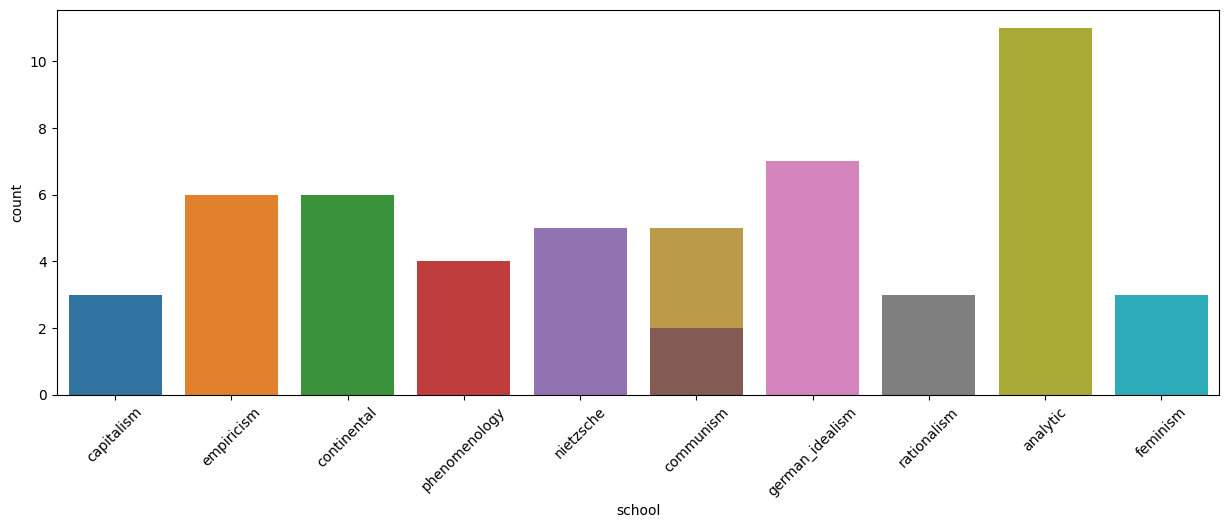

In [84]:
# Load the dataset
df = pd.read_csv("data/dataset.csv")

# Number of individuals and list the columns in the dataset
print(f"Number of individuals: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")
print(f"Name of columns: {df.columns.to_list()}")


# Counting the different values
print(f"Number of unique authors: {len(pd.unique(df.author))}")
print(f"Number of unique schools: {len(pd.unique(df.school))}")
print(f"Number of authors per school of thoughts: {df.groupby(['school']).count()['author']}")

# Plotting the data
sns.countplot(x="author", data=df)
plt.xticks(rotation=45)

# Plotting the data
sns.countplot(x="school", data=df)
plt.xticks(rotation=45)

## Cleaning up the data
Textual should be:

- Lemmed
- Cleaned from stop words and punctuation.
  
We will do it using spacy built-in features.

In [88]:
nlp = spacy.load("en_core_web_sm")
# Take the first sentence from the dataset
test_sentence = df["sentence_str"].iloc[0]
# Run it through spacy nlp function
doc = nlp(test_sentence)

# You can now iteratively access the different parsed version of the words
for token in doc[:1]:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_, token.shape_, token.is_alpha, token.is_stop)

There there PRON EX expl Xxxxx True True


**Exercice**:
1. Compute for each book the uncapitalized_text (using the `.lower()` function) and lemmed_text from spacy.
1. Add 2 new columns to the dataframe: `uncapitalized_text`and `lemmed_text`.
3. Add a new column `cleaned_text` which contains the final text: start with the column `lemmed_text` and remove the stop words contained in `spacy.lang.en.stop_words.STOP_WORDS`.

In [108]:
# Compute the uncapitalized text using the .lower() and compute the lemmed text
# Two possible solutions
uncapitalized_text = df.sentence_str.apply(lambda x: x.lower())
uncapitalized_text = df.sentence_str.str.lower()
df["uncapitalized_text"] = uncapitalized_text

# Compute the lemmed text
lemmed_text = []
for book in df.uncapitalized_text:
    doc = nlp(book)
    lemmed_text.append(' '.join([token.lemma_ for token in doc]))
df["lemmed_text"] = lemmed_text
    
# Compute the text without stop words
df["cleaned_text"] = df.lemmed_text.apply(lambda x: ' '.join([word for word in x.split(" ") if word not in spacy.lang.en.stop_words.STOP_WORDS])) 

## Analyzing vocabulary use

Using the `sklearn` library (see slides in lectures), it is easy to compute word counts using the `CountVectorizer` class.

In [110]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [120]:
# Initialize 
count_vect = CountVectorizer(stop_words=list(spacy.lang.en.STOP_WORDS))

# Fit on the clean column
count_vect.fit(df.sentence_str)

# Get count matrix
count_matrix = count_vect.transform(df.cleaned_text).todense()

# Create as dataframe
count_df_ = pd.DataFrame(count_matrix, columns=count_vect.get_feature_names_out(), index=df.title)

# Merge with df to get information
# Careful, new column names will have _y appended
count_df = count_df_.merge(df[["title","school", "author"]], left_index=True, right_on="title", suffixes=("", "_value"))

/home/mimsy/Documents/dev/nlp/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


`count_df` is now a dataframe with the number of words per text, as well as the information regarding the books. The information regarding the books is suffixed by the value `_value`.
`count_df_` is a dataframe with the number of words per text.

**Exercice**:
1. Give the 5 most frequent words.
2. Find for each book the number of times the word `man` and `woman` is used.
3. Find the book that uses most often the word `essence`.
4. Give for each school of thought the 25 most often used words and print them.
5. Create a new list called `columns_to_filter` that contains for each author the 25 words with the highest tf-idf.
6. Create a new dataframe called `filtered_df` which contains the previously filtered column.

**Bonus**:
- Find the school of thought that uses most of then word `god`.
- Perform the same exercise (you can copy paste the code) using tf-idf (`TfidfVectorizer`)

In [194]:
# 5 most frequent words
count_df_.sum().sort_values(ascending=False).head(5)

# Number of times man and woman is used per book
count_df_["man"]
count_df_["woman"]

# Book with the most of times the word essence
count_df_["essence"].sort_values(ascending=False).head(1)

# School of thought using the word God the most often
count_df.groupby("school_value").sum()["god"].sort_values(ascending=False).head(1)

# For each school of thought the 25 most often used words
most_used_words = []
for school in pd.unique(df.school):
    most_used_words.extend(count_df.loc[count_df.school_value == school].drop(["title_value", "school_value", "author_value"], axis=1).sum().sort_values(ascending=False)[:26].index)

# Filter using these words
filtered_df = count_df[most_used_words]

## Performing k-means clustering

We are going to use k-means clustering (see lecture slides) to group works that are the most similar in terms of vocabulary use, using the class `KMeans`. 

In [201]:
from sklearn.cluster import KMeans

kmeans= KMeans(n_clusters=11, n_init="auto")
kmeans.fit(count_df_)
labels = kmeans.labels_

The `labels` list contains for each title its associated cluster.

**Exercice**:
1. Assign the `labels` column to the `count_df` dataframe.
4. Provide the list of titles / author / school within each cluster.
5. Give the 10 words with the highest term frequency per cluster.
6. Conclude regarding overlap in topics.
   
**Bonus**:
1. Select the optimum number of clusters by analyzing the inertia for each value of k.
2. Test using the `DBScan` algorithm.

In [227]:
# Assign the labels to the dataframe
count_df.labels = labels

# Provide the list of titles / author / school within each cluster
for label in pd.unique(count_df.labels):
    print("=====================")
    print("======================")
    print("=====================")
    print(f"Title in cluster {label}")
    print(count_df[count_df.labels == label]["title_value"].values)

    print("=====================")
    print(f"Author in cluster {label}")
    print(pd.unique(count_df[count_df.labels == label]["author_value"].values))

    print("=====================")
    print(f"School in cluster {label}")
    print(pd.unique(count_df[count_df.labels == label]["school_value"].values))


# Give the 10 words with the highest term frequency per cluster.
    print("=====================")
    print(f"Word in cluster {label}")
    print(count_df.loc[count_df.labels == label].drop(["title_value", "school_value", "author_value"], axis=1).sum().sort_values(ascending=False)[:10].index)


Title in cluster 6
['A General Theory Of Employment, Interest, And Money']
Author in cluster 6
['Keynes']
School in cluster 6
['capitalism']
Word in cluster 6
Index(['money', 'wage', 'investment', 'rate', 'fall', 'demand', 'long',
       'capital', 'employment', 'income'],
      dtype='object')
Title in cluster 4
['A Treatise Concerning The Principles Of Human Knowledge'
 'Essay Concerning Human Understanding' 'Ethics'
 'The Problems Of Philosophy' 'The Search After Truth' 'Three Dialogues']
Author in cluster 4
['Berkeley' 'Locke' 'Spinoza' 'Russell' 'Malebranche']
School in cluster 4
['empiricism' 'rationalism' 'analytic']
Word in cluster 4
Index(['idea', 'thing', 'mind', 'man', 'object', 'know', 'body', 'god',
       'nature', 'word'],
      dtype='object')
Title in cluster 5
['A Treatise Of Human Nature' 'Anti-Oedipus' 'Beyond Good And Evil'
 'Dialogues Concerning Natural Religion' 'Ecce Homo' 'History Of Madness'
 'Second Treatise On Government' 'The Antichrist'
 'The Birth Of The 

## Bonus: Projecting into a lower space

We are going to use `PCA` (see slides in lecture) to project the different books in a reduced 2 dimensional space and to visually analyze their similarity.

In [189]:
from sklearn.decomposition import PCA

# Reduce into a 2 dimension matrix
pca = PCA(n_components=20)

# Train and retrieve output
reduced_pca = pca.fit_transform(count_df_)

**Exercice:**
1. Plot the scatter plot into the 2 dimensional space.
2. Color the graph per author.
3. Add the title of each book using plt.annotate.
4. Can you infer anything regarding the distribution in the reduced space ?
5. Perform the same exercice on `filtered_df`.

**Bonus**: 
- Find explained variance ratio using the attribute `pca.explained_variance_ratio_`.
- Analyze axis meaning by plotting the different components and their associated word.